# Improve SalePrice Prediction Score with Preprocessing and Feature Engineering

- This notebook looks at the prediction score improvement after applying feature preprocessing and feature engineering methods to the Ames dataset. The performance of models is compared with this [baseline model]( https://www.kaggle.com/neslee/housing-price-competition?scriptVersionId=49500241) with cross-validation.
- Dataset was collected by Dean De Cock and contains attributes of individual residential properties sold in Ames, Iowa from 2006 to 2010, and was split into train and test datasets. Models in this notebook will only use the training data to get the loss score - mean absolute error, as this is the same loss function used by the baseline model.
- At the end of the notebook, I look at the model errors, and see where highest errors occur.

In [1]:
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from category_encoders import ordinal
from category_encoders import one_hot
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RepeatedStratifiedKFold
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [2]:
train_path = "train.csv"
train_df = pd.read_csv(train_path, index_col = 'Id')
print(train_df.shape)
train_df.head()

(1460, 80)


MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                     
1          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
2          Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
3          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
4          Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
5          Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                       
1        Norm     1Fam     2Story            7            5       2003   
2        Norm     1Fam     1Story            6            8       1976   
3        Norm     1Fam     2Story            7            5       2001   
4        Norm     1Fam     2Story            7            5       1915   
5        Norm     1Fam     2Story            8            5       2000   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                       
1           2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
2           1976     Gable  CompShg     MetalSd     MetalSd       None   
3           2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4           1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
5           2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
Id                                                                             
1        196.0        Gd        TA      PConc       Gd       TA           No   
2          0.0        TA        TA     CBlock       Gd       TA           Gd   
3        162.0        Gd        TA      PConc       Gd       TA           Mn   
4          0.0        TA        TA     BrkTil       TA       Gd           No   
5        350.0        Gd        TA      PConc       Gd       TA           Av   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                             
1           GLQ         706          Unf           0        150          856   
2           ALQ         978          Unf           0        284         1262   
3           GLQ         486          Unf           0        434          920   
4           ALQ         216          Unf           0        540          756   
5           GLQ         655          Unf           0        490         1145   

   Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
Id                                                                             
1     GasA        Ex          Y      SBrkr       856       854             0   
2     GasA        Ex          Y      SBrkr      1262         0             0   
3     GasA        Ex          Y      SBrkr       920       866             0   
4     GasA        Gd          Y      SBrkr       961       756             0   
5     GasA        Ex          Y      SBrkr      1145      1053             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
Id                                                                            
1        1710             1             0         2         1             3   
2        1262             0             1  

In [3]:
train_df.describe(include = "all")

MSSubClass MSZoning  LotFrontage        LotArea Street Alley  \
count   1460.000000     1460  1201.000000    1460.000000   1460    91   
unique          NaN        5          NaN            NaN      2     2   
top             NaN       RL          NaN            NaN   Pave  Grvl   
freq            NaN     1151          NaN            NaN   1454    50   
mean      56.897260      NaN    70.049958   10516.828082    NaN   NaN   
std       42.300571      NaN    24.284752    9981.264932    NaN   NaN   
min       20.000000      NaN    21.000000    1300.000000    NaN   NaN   
25%       20.000000      NaN    59.000000    7553.500000    NaN   NaN   
50%       50.000000      NaN    69.000000    9478.500000    NaN   NaN   
75%       70.000000      NaN    80.000000   11601.500000    NaN   NaN   
max      190.000000      NaN   313.000000  215245.000000    NaN   NaN   

       LotShape LandContour Utilities LotConfig LandSlope Neighborhood  \
count      1460        1460      1460      1460      1460         1460   
unique        4           4         2         5         3           25   
top         Reg         Lvl    AllPub    Inside       Gtl        NAmes   
freq        925        1311      1459      1052      1382          225   
mean        NaN         NaN       NaN       NaN       NaN          NaN   
std         NaN         NaN       NaN       NaN       NaN          NaN   
min         NaN         NaN       NaN       NaN       NaN          NaN   
25%         NaN         NaN       NaN       NaN       NaN          NaN   
50%         NaN         NaN       NaN       NaN       NaN          NaN   
75%         NaN         NaN       NaN       NaN       NaN          NaN   
max         NaN         NaN       NaN       NaN       NaN          NaN   

       Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  \
count        1460       1460     1460       1460  1460.000000  1460.000000   
unique          9          8        5          8          NaN          NaN   
top          Norm       Norm     1Fam     1Story          NaN          NaN   
freq         1260       1445     1220        726          NaN          NaN   
mean          NaN        NaN      NaN        NaN     6.099315     5.575342   
std           NaN        NaN      NaN        NaN     1.382997     1.112799   
min           NaN        NaN      NaN        NaN     1.000000     1.000000   
25%           NaN        NaN      NaN        NaN     5.000000     5.000000   
50%           NaN        NaN      NaN        NaN     6.000000     5.000000   
75%           NaN        NaN      NaN        NaN     7.000000     6.000000   
max           NaN        NaN      NaN        NaN    10.000000     9.000000   

          YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
count   1460.000000   1460.000000      1460     1460        1460        1460   
unique          NaN           NaN         6        8          15          16   
top             NaN           NaN     Gable  CompShg     VinylSd     VinylSd   
freq            NaN           NaN      1141     1434         515         504   
mean    1971.267808   1984.865753       NaN      NaN         NaN         NaN   
std       30.202904     20.645407       NaN      NaN         NaN         NaN   
min     1872.000000   1950.000000       NaN      NaN         NaN         NaN   
25%     1954.000000   1967.000000       NaN      NaN         NaN         NaN   
50%     1973.000000   1994.000000       NaN      NaN         NaN         NaN   
75%     2000.000000   2004.000000       NaN      NaN         NaN         NaN   
max     2010.000000   2010.000000       NaN      NaN         NaN         NaN   

       MasVnrType   MasVnrArea ExterQual ExterCond Foundation BsmtQual  \
count        1452  1452.000000      1460      1460       1460     1423   
unique          4          NaN         4         5          6        4   
top          None          NaN        TA        TA      PConc       TA   
freq          864          NaN       906      128

## Sale Price Distribution

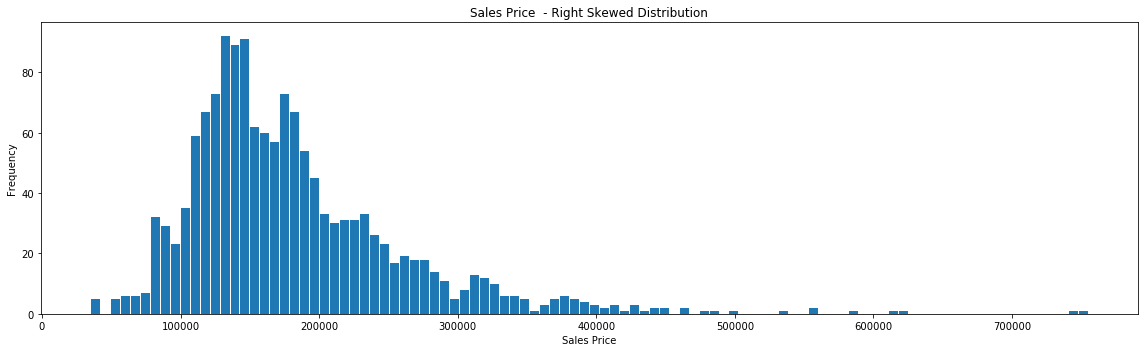

In [4]:
plt.figure(figsize=(16,5))
train_df["SalePrice"].plot(kind="hist", bins=100, rwidth=0.9)
plt.title("Sales Price  - Right Skewed Distribution")
plt.xlabel("Sales Price")
plt.tight_layout()
plt.show()

In [5]:
print("Number of houses sold for more than 400,000$ = ", (train_df["SalePrice"] > 400000).sum())

Number of houses sold for more than 400,000$ =  28


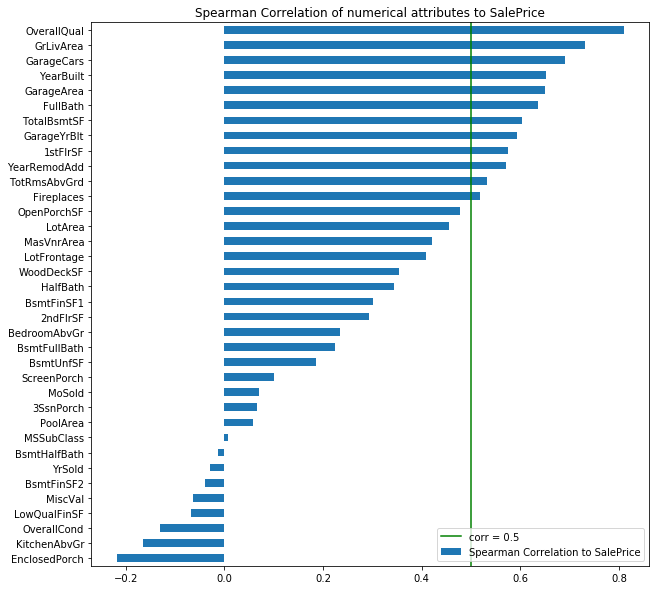

In [6]:
corr = train_df.corr(method="spearman")

plt.figure(figsize=(10,10));
corr["SalePrice"].sort_values(ascending=True)[:-1].plot(kind="barh", label="Spearman Correlation to SalePrice")
plt.title("Spearman Correlation of numerical attributes to SalePrice")
plt.axvline(x=0.5, color="g", label="corr = 0.5")
plt.legend()
plt.show()

- Overall material and finish of the house, size of the house and garage, remodeling date, and number of fireplaces have a positive correlation to the Sale Price. 
- Investigate: OverallCond and Misc value have negative correlation to Sale Price 

## Evaluation with cross-validation

In [7]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=13)
target_scores = ["neg_mean_absolute_error"]

def evaluate_model(X, y, pipeline):    
    results = cross_validate(pipeline, X, y, scoring="neg_mean_absolute_error", cv = cv, return_train_score=True, n_jobs=-1) 
    for m in ["test_score", "train_score"]:         
        mae = results[m] * -1
        print("{}:{:0.2f}, +/- {:0.2f}".format(m, mae.mean(), mae.std()))
    return results

## Baseline RandomForest Model
This is copy paste from the starter notebook, here, I'm using cross validation instead of train test split eval to get a more reliable comparison of performance.


In [8]:
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
base_X = train_df[features]
base_y = train_df["SalePrice"]

base_model = RandomForestRegressor(random_state=1)
base_test_score = evaluate_model(base_X, base_y, base_model)["test_score"].mean() * -1

test_score:22573.52, +/- 2593.00
train_score:8396.70, +/- 108.85


## Use all attributes, preprocess them and measure performance

### Target and target related attributes
- The goal is to predict the sale price, I'm going to drop all features related to the sale event. 


In [9]:
target = "SalePrice"
target_related = ["MoSold", "YrSold", "SaleType", "SaleCondition"]
invariant = ["Utilities", "Street"]
clean_df = train_df.drop(target_related + invariant, axis = 1)
clean_df = clean_df[train_df["GrLivArea"] < 4000]

In [10]:
X = clean_df.drop([target], axis=1)
y = clean_df[target]

### Preprocess
- Identify and process ordinal attributes, prepare mapping for the encoder
- Identify categorical attributes, prepare one hot encoder which replaces null values with an indicator: nan
- Identify numeric attributes, identify columns where null values should be replaced with 0, rest of the attributes will be replaced by the median value.

In [11]:
# Identify column types
numerics = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MiscVal', 'PoolArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                'GarageCars', 'GarageArea', 'GarageYrBlt','Fireplaces', 'TotRmsAbvGrd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
                'FullBath','HalfBath', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFinSF1', 'MasVnrArea','YearRemodAdd', 'YearBuilt', 'KitchenAbvGr', 'BedroomAbvGr']

categoricals = ['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle','MiscFeature','GarageType', 'Electrical', 'Heating','Foundation', 'RoofStyle','RoofMatl','Exterior1st',
                'Exterior2nd','MasVnrType', 'LandSlope', 'LotShape']

ordinals =['PoolQC','Fence', 'GarageQual', 'GarageCond', 'PavedDrive', 'GarageFinish', 'FireplaceQu', 'Functional', 'KitchenQual',
            'HeatingQC', 'CentralAir', 'BsmtFinType2', 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1', 'ExterQual','ExterCond', 'Alley']

In [12]:
print(len(numerics) + len(categoricals) + len(ordinals), "features")

73 features


### Clean ordinal attributes

In [13]:
# Setup ordering for ordinal attributes
pool_qc = ['Fa', 'TA', 'Gd', 'Ex']
fence = ['MnWw', 'MnPrv', 'GdWo', 'GdPrv']
garage_qual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
garage_cond = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
paved_drive = ['P', 'Y']
garage_finish = ['Unf', 'RFn', 'Fin']
fireplace_qual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
functional = ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
kitchen_qual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
heating_qc = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
central_air = ['N', 'Y']
bsmt_fintype2 = ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
bsmt_qual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
bsmt_cond = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
bsmt_exp = ['No', 'Mn', 'Av', 'Gd']
bsmt_fintype1 = ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
external_qual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
external_cond = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
alley = ['Grvl', 'Pave']

# Construct Mapping dictionary for ordinals
mappings=[pool_qc,fence,garage_qual,garage_cond,paved_drive,garage_finish,fireplace_qual,
            functional,kitchen_qual,heating_qc,central_air,bsmt_fintype2,bsmt_qual,bsmt_cond,
            bsmt_exp,bsmt_fintype1,external_qual,external_cond, alley]


ordinal_mappings = []

assert len(ordinals) == len(mappings)

for i in range(0, len(ordinals)):
    root_dict = {'col': ordinals[i]}
    mapping_dict = {None: 0, np.nan: 0}
    ordered_lst = mappings[i]

    for j in range(0, len(ordered_lst)):
        mapping_dict[ordered_lst[j]] = j+1

    root_dict["mapping"] = mapping_dict
    ordinal_mappings.append(root_dict)
    
assert len(ordinal_mappings) == len(ordinals)

print(ordinal_mappings)

[{'col': 'PoolQC', 'mapping': {None: 0, nan: 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}}, {'col': 'Fence', 'mapping': {None: 0, nan: 0, 'MnWw': 1, 'MnPrv': 2, 'GdWo': 3, 'GdPrv': 4}}, {'col': 'GarageQual', 'mapping': {None: 0, nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}}, {'col': 'GarageCond', 'mapping': {None: 0, nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}}, {'col': 'PavedDrive', 'mapping': {None: 0, nan: 0, 'P': 1, 'Y': 2}}, {'col': 'GarageFinish', 'mapping': {None: 0, nan: 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}}, {'col': 'FireplaceQu', 'mapping': {None: 0, nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}}, {'col': 'Functional', 'mapping': {None: 0, nan: 0, 'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}}, {'col': 'KitchenQual', 'mapping': {None: 0, nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}}, {'col': 'HeatingQC', 'mapping': {None: 0, nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}}, {'col': 'CentralAir', 'mapping': {None

### Clean categoricals
This is just a sample of corrections we can do with categorical atributes. Further binning of categorical levels may improve prediction score.

In [14]:
def preprocess_categoricals(df):
    df["MSSubClass"] = df["MSSubClass"].replace(to_replace ={40 : 45})
    df["LandContour"] = df["LandContour"].replace(to_replace={"FR3": "FR2"})
    df["MiscFeature"] = df["MiscFeature"].replace(to_replace={"Gar2": "NotShed", "Othr": "NotShed", "TenC": "NotShed", np.nan: "NotShed"})

In [15]:
preprocess_categoricals(X)

In [16]:
DataFrameSummary(X).missing_frac[DataFrameSummary(X).missing_frac > 0]

LotFrontage     0.177885
Alley           0.937500
MasVnrType      0.005495
MasVnrArea      0.005495
BsmtQual        0.025412
BsmtCond        0.025412
BsmtExposure    0.026099
BsmtFinType1    0.025412
BsmtFinType2    0.026099
Electrical      0.000687
FireplaceQu     0.473901
GarageType      0.055632
GarageYrBlt     0.055632
GarageFinish    0.055632
GarageQual      0.055632
GarageCond      0.055632
PoolQC          0.996566
Fence           0.807692
Name: missing, dtype: float64

SimpleImputer will fill these null values with 0 or median value depending on the column.

### Clean Numerics

In [17]:
numerics_should_be_zero = ["LotFrontage", "MasVnrArea"]
print(len(numerics))
numerics_replace_with_median = list(set(numerics) - set(numerics_should_be_zero))
print(len(numerics_replace_with_median))

33
31


In [18]:
# Define pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

ordinal_transform = Pipeline(steps = [
    ('ord', ordinal.OrdinalEncoder(verbose=1,cols=ordinals, mapping=ordinal_mappings, handle_unknown="value", handle_missing="value"))
        
])

categorical_transform = Pipeline(steps = [
    
    ('cat', one_hot.OneHotEncoder(verbose=1, cols=categoricals, use_cat_names = True, handle_unknown="value", handle_missing="value"))
        
])

impute_with_zeros = Pipeline(steps = [
    ('zeroes', SimpleImputer(strategy="constant", fill_value=0)),
    ('scl1', StandardScaler())    
])

impute_with_medians = Pipeline(steps = [
    ('zeroes', SimpleImputer(strategy="median")),
    ('scl2', StandardScaler())
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('zeros', impute_with_zeros, numerics_should_be_zero),
        ('median', impute_with_medians, numerics),
        ('categoricals', categorical_transform, categoricals),
        ('ordinals', ordinal_transform, ordinals)
    ])

So far, we added all features, and identified ordinal columns, one hot encoded categorical columns, and dropped invariant columns. Let's measure the performance.

In [19]:
model = RandomForestRegressor(random_state=1)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('lr', model)])
v1_test_score = evaluate_model(X, y, pipeline)['test_score'].mean() * -1

test_score:16663.42, +/- 1283.06
train_score:6237.59, +/- 94.56


In [20]:
print("By using all attributes and doing some preprocessing, we improved the score by: {:.1f}%."
      .format((1 - (v1_test_score / base_test_score))*100))

By using all attributes and doing some preprocessing, we improved the score by: 26.2%.


## Feature Engineering ( Add new features)

In [21]:
# ordinal encoding
ordinal_encoder = ordinal.OrdinalEncoder(verbose=1, cols=ordinals, drop_invariant=False, mapping=ordinal_mappings, handle_unknown="value", handle_missing="value")
X = ordinal_encoder.fit_transform(X)

In [22]:
# categorical encoding
onehot_encoder = one_hot.OneHotEncoder(cols=categoricals, drop_invariant=True, return_df = True, use_cat_names = True, handle_unknown="value", handle_missing="value")
X = onehot_encoder.fit_transform(X)

In [23]:
def add_features(df):
    """Do this as the last step after preprocessing"""
    # Area sums
    df["IndoorArea"] = df["GrLivArea"] + df["TotalBsmtSF"]
    df["FloorsArea"] = df["1stFlrSF"] + df["2ndFlrSF"]
    df["PorchArea"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]
    
    new_numerics =["IndoorArea", "FloorsArea", "PorchArea"]
    
    # Quality
    df["OverallGrade"] = df["OverallQual"] * df["OverallCond"]    
    df["ExterGrade"] = df["ExterQual"] * df["ExterCond"]
    df["KitchenGrade"] = df["KitchenAbvGr"] * df["KitchenQual"]
    df["FireplaceGrade"] = df["Fireplaces"] * df["FireplaceQu"]
    df["GarageGrade"] = df["GarageArea"] * df["GarageQual"]
    df["PoolGrade"] = df["PoolArea"] * df["PoolQC"]
    
    new_numerics += ["OverallGrade", "GarageGrade", "ExterGrade", "KitchenGrade","FireplaceGrade", "PoolGrade"]
    
    # Basement
    df["TotalFinishedBsmt"] = df["BsmtFinSF2"] * df["BsmtFinSF1"]
    df["BsmtGrade"] = df["BsmtQual"] * df["BsmtCond"]
    df["BsmtAreaCondition"] = df["BsmtCond"] * df["TotalBsmtSF"]
    df["FinishedBsmtScore1"] = (df["BsmtFinSF2"] + df["BsmtFinSF1"]) * (df["BsmtFinType1"] + df["BsmtFinType2"])
    df["FinishedBsmtScore2"] = df["TotalFinishedBsmt"] * df["BsmtQual"]
    
    new_numerics += ["TotalFinishedBsmt", "BsmtGrade", "BsmtAreaCondition", "FinishedBsmtScore1", "FinishedBsmtScore2"]
    
    # Bathroom
    df["TotalFullBath"] = df["FullBath"] + df["BsmtFullBath"]
    df["TotalHalfBath"] = df["HalfBath"] + df["BsmtHalfBath"]

    new_numerics += ["TotalFullBath", "TotalHalfBath"]

    # Garage 
    df["GarageCarArea"] = df.apply(lambda row: (row["GarageArea"] / row["GarageCars"]) if (row["GarageArea"] != 0 and row["GarageCars"] != 0) else 0, axis=1)
    df["GarageCarQuality"] = df["GarageQual"] * df["GarageCars"]
    
    new_numerics += ["GarageCarArea", "GarageCarQuality"]
    
    # Neighborhoods
    neighborhoods = [col for col in df if col.startswith("Neighborhood")]
    for n in neighborhoods:
        df[n+"_Lot"] = df[n] * df["LotArea"]
    new_neighborhoods = [n+"_Lot" for n in neighborhoods]
    
    # return the new column names
    return new_numerics + new_neighborhoods

In [24]:
print("Before adding new features = ", len(numerics))
new_features = add_features(X)
print("After adding new features = ", len(new_features))
numerics += new_features
print("Features = ", numerics)
print("Total numeric features = ", len(numerics))

Before adding new features =  33
After adding new features =  43
Features =  ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MiscVal', 'PoolArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'GarageCars', 'GarageArea', 'GarageYrBlt', 'Fireplaces', 'TotRmsAbvGrd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFinSF1', 'MasVnrArea', 'YearRemodAdd', 'YearBuilt', 'KitchenAbvGr', 'BedroomAbvGr', 'IndoorArea', 'FloorsArea', 'PorchArea', 'OverallGrade', 'GarageGrade', 'ExterGrade', 'KitchenGrade', 'FireplaceGrade', 'PoolGrade', 'TotalFinishedBsmt', 'BsmtGrade', 'BsmtAreaCondition', 'FinishedBsmtScore1', 'FinishedBsmtScore2', 'TotalFullBath', 'TotalHalfBath', 'GarageCarArea', 'GarageCarQuality', 'Neighborhood_CollgCr_Lot', 'Neighborhood_Veenker_Lot', 'Neighborhood_Crawfor_Lot', 'Neighborhood_NoRidge_Lot', 'Neighborhood_Mitchel_Lot', 'Neighborhood

In [25]:
# replace nulls with median
numerics_replace_with_median = list(set(numerics) - set(numerics_should_be_zero))
print(len(numerics_replace_with_median))

74


In [26]:
# Define pipeline
impute_with_zeros = Pipeline(steps = [
    ('zeroes', SimpleImputer(strategy="constant", fill_value=0)),
    ('scl1', StandardScaler())    
])

impute_with_medians = Pipeline(steps = [
    ('zeroes', SimpleImputer(strategy="median")),
    ('scl2', StandardScaler())
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('zeros', impute_with_zeros, numerics_should_be_zero),
        ('median', impute_with_medians, numerics_replace_with_median)        
    ], remainder = "passthrough")

## Train RandomForestRegressor with new features added

In [27]:
model = RandomForestRegressor(random_state=1)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('lr', model)])
v2_test_score = evaluate_model(X, y, pipeline)["test_score"].mean() * -1

test_score:15924.81, +/- 1291.49
train_score:5969.91, +/- 72.67


In [28]:
print("By adding new features, we improved the score by: {:.1f}%."
      .format((1 - (v2_test_score / base_test_score))*100))

By adding new features, we improved the score by: 29.5%.


New features added aditional 3% improvement. Let's look at the feature importance.

## Feature Importance
The model is overfitting, one way to handle this to filter out the attributes not used by the model.  

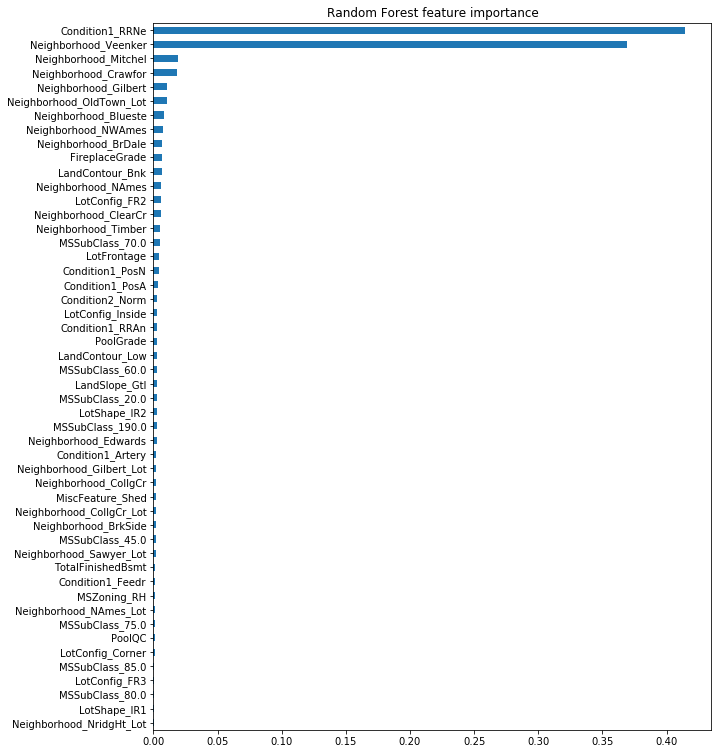

In [29]:
pipeline.fit(X, y)
coeffs = model.feature_importances_
df_co = pd.DataFrame(coeffs, columns=["importance_"])
df_co.index = X.columns
# get top 50 features
df_co.sort_values("importance_", ascending=True, inplace=True)

plt.figure(figsize=(10,13))
df_co.iloc[-50:, :].importance_.plot(kind="barh")
plt.title(f"Random Forest feature importance")
plt.show()

## Model errors

In [30]:
def plot(y_train_pred, y_test_pred, y_train, y_test, title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
    
    # Plot errors    
    ax1.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
    ax1.scatter(y_test_pred, y_test_pred - y_test, c = "green", marker = "s", label = "Validation data")
    ax1.set_title(title + " Errors")
    ax1.set_xlabel("Predicted values")
    ax1.set_ylabel("Errors")
    ax1.legend(loc = "best")
    ax1.hlines(y = 0, xmin = 0, xmax = 800000, color = "red")

    # Plot predictions
    ax2.scatter(y_train, y_train_pred, c = "blue", marker = "s", label = "Training data")
    ax2.scatter(y_test, y_test_pred, c = "green", marker = "s", label = "Validation data")
    ax2.set_title(title + " Errors")
    ax2.set_xlabel("Real values")
    ax2.set_ylabel("Predicted values")
    ax2.legend(loc = "best")
    ax2.plot([0, 800000], [0, 800000], c = "red")
    plt.show()
    
def mae(y_pred, y):
    return abs(y_pred - y).mean()

Train:  6079.321815505397
Test:  17913.071441647597


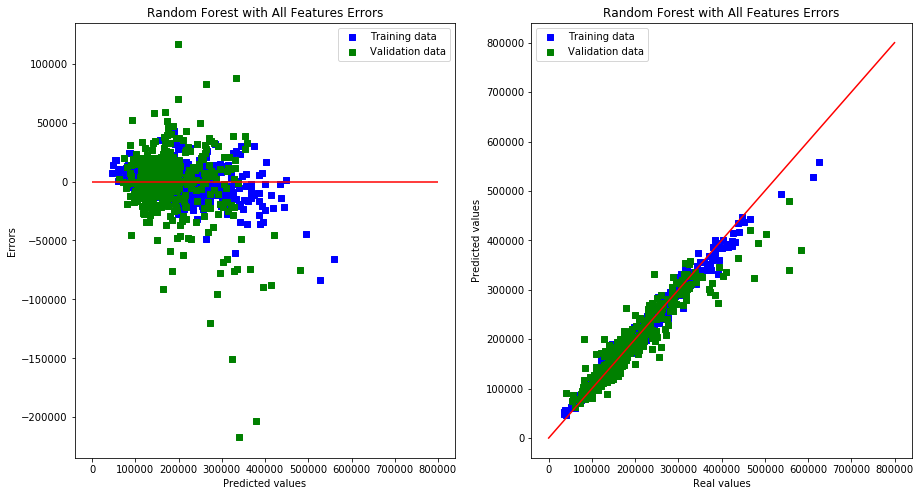

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 13)

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print("Train: ", mae(y_train_pred, y_train))
print("Test: ", mae(y_test_pred, y_test))

plot(y_train_pred, y_test_pred, y_train, y_test, "Random Forest with All Features")

- Model tends to understimate the sale price for houses that are sold more than 500,000. This might be related to the skewed distribution or very few number of data points ~28.
- As the model is overfitting, validation errors go as high as 200,000.

**Next steps:**
- Handle overfitting: find a better subset of features
- Look at the instances where errors are highest